 ## What does this code do?



 We compute simple returns $ r_{ji} = P_{ji} - P_{j, i-1} $  for the $j$-th market at interval $i$.



 Because prices can be zero or negative, log returns are not applicable.



 Following Andersen et al. (2001) and Bollerslev et al. (2020), we estimate the realized daily variation and covariation using the covariance matrix definition:


$$
\text{ReCov} = \sum_{i=1}^m r_i r_i' = 
\begin{bmatrix}
\text{ReVar}_{FR} & \text{ReCov}_{FR-ES} & \text{ReCov}_{FR-PT} \\
\text{ReCov}_{ES-FR} & \text{ReVar}_{ES} & \text{ReCov}_{ES-PT} \\
\text{ReCov}_{PT-FR} & \text{ReCov}_{PT-ES} & \text{ReVar}_{PT}
\end{bmatrix}
$$




 To prepare for the multivariate HAR (MHAR) model (Corsi, 2009), we apply a **variance stabilizer** based on the Probability Integral Transform (PIT) following Uniejewski et al. (2017):

 $$

 Z_t = G^{-1}(\hat{F}(X_t))

 $$

 where $X_t$ is the realized measure, $\hat{F}$ its estimated CDF, and $G^{-1}$ the inverse standard normal CDF.



 This transformation is used to approximate normality of the realized measures, which is important for the generalized variance decomposition step.

 ## Step 1: Load data

In [ ]:
# Import libraries

# File-system & serialization
import os
import json

# Data manipulation & numerical computing
import numpy as np
import pandas as pd

# Statistics & distributions
from scipy.stats import norm, rankdata
import statsmodels.api as sm

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive widgets (Jupyter UI) and notebook display helpers
import ipywidgets as widgets
from IPython.display import display, clear_output


In [2]:
# Create dropdown
option_selector = widgets.Dropdown(
    options=['europe', 'australia'],
    value='europe',  # initial default
    description='Dataset:',
    disabled=False,
)

# Create button
button = widgets.Button(
    description="Load Dataset",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to load selected dataset',
    icon='check'  # (optional) FontAwesome icon
)

# Define button click handler
def on_button_click(b):
    global df
    clear_output(wait=True)  # Clears previous output to keep it clean
    display(option_selector, button)  # Re-display widgets after clear
    
    selected_option = option_selector.value
    
    if selected_option == 'europe':
        file_path = 'parquet_files/filtered_data.parquet'
        try:
            df = pd.read_parquet(file_path)
            print(f"Europe dataset loaded from {file_path}.")
            print(df.head())
        except Exception as e:
            print(f"Error loading Europe dataset: {e}")
    
    elif selected_option == 'australia':
        file_path = 'parquet_files/filtered_data_australia.parquet'
        try:
            df = pd.read_parquet(file_path)
            print(f"Australia dataset loaded from {file_path}.")
            print(df.head())
        except Exception as e:
            print(f"Error loading Australia dataset: {e}")

# Attach button click handler
button.on_click(on_button_click)

# Display UI
display(option_selector, button)

Dropdown(description='Dataset:', options=('europe', 'australia'), value='europe')

Button(button_style='success', description='Load Dataset', icon='check', style=ButtonStyle(), tooltip='Click t…

In [3]:
# Pivot the dataframe
df = df.sort_values(['Area', 'Start DateTime'])
df['Start DateTime Unique'] = df['Start DateTime']

# Pivot to get prices in wide format (rows = times, columns = markets)
df_pivot = df.pivot(index='Start DateTime Unique', columns='Area', values='Day-ahead Price (EUR/MWh)').sort_index()
df_pivot.head(5)


Area,BZN|ES,BZN|FR,BZN|PT
Start DateTime Unique,,,
2021-05-21 00:00:00,80.85,37.24,80.85
2021-05-21 01:00:00,79.46,22.90,79.46
2021-05-21 02:00:00,79.18,14.29,79.18
2021-05-21 03:00:00,79.18,7.83,79.18
2021-05-21 04:00:00,79.46,7.08,79.46


 ## Step 2: Compute simple returns

In [4]:
# Calculate simple returns: \(r_{ji} = P_{ji} - P_{j,i-1}\)
simple_returns = df_pivot.diff().dropna()
simple_returns.head(5)


Area,BZN|ES,BZN|FR,BZN|PT
Start DateTime Unique,,,
2021-05-21 01:00:00,-1.39,-14.34,-1.39
2021-05-21 02:00:00,-0.28,-8.61,-0.28
2021-05-21 03:00:00,0.00,-6.46,0.00
2021-05-21 04:00:00,0.28,-0.75,0.28
2021-05-21 05:00:00,-0.28,9.61,-0.28


 ## Step 3: Calculate daily realized covariance matrices

In [ ]:
###############################################################################
#     Daily realised-covariance from intraday simple returns
#     ------------------------------------------------------
#     simple_returns  : hourly return series
#                      index  → timezone-aware timestamps (hh:mm)
#                      columns → price areas  
###############################################################################

# Add a pure-date column so we can group by calendar day
simple_returns['Date'] = simple_returns.index.date    

# Prepare a dict to collect one covariance matrix per day
daily_covariances = {}

# Loop over each day’s slice of the DataFrame
for day, group in simple_returns.groupby('Date'):
    # a) Remove the helper column; we only need numeric returns from now on
    returns_only = group.drop(columns='Date')          # shape (T×N)

    # b) Start an empty N×N accumulator (N = number of areas)
    cov_matrix = np.zeros((returns_only.shape[1],
                           returns_only.shape[1]))

    # c) Iterate over the T intraday observations
    for i in range(returns_only.shape[0]):
        #    r is a column vector of returns for all areas at that timestamp
        r = returns_only.iloc[i].values.reshape(-1, 1)   # shape (N×1)

        #    Outer product r · rᵀ → N×N matrix of cross-products for this hour
        cov_matrix += r @ r.T                            # accumulate

    # d) Store the realised-covariance matrix in a dict under its date key
    daily_covariances[day] = pd.DataFrame(
        cov_matrix,
        index=returns_only.columns,                     # row labels
        columns=returns_only.columns                    # col labels
    )





In [ ]:
# Quick sanity checks
first_key, first_value = next(iter(daily_covariances.items()))
print(first_key) 
print(first_value)   
print('Matrix is symmetric:', np.allclose(first_value, first_value.T))
shapes = {mat.shape for mat in daily_covariances.values()}
print('We have matrices of shapes:', shapes)            # {(3, 3)}

2021-05-21
Area      BZN|ES     BZN|FR    BZN|PT
Area                                 
BZN|ES  900.7055   610.1282  849.2810
BZN|FR  610.1282  3308.8123  396.1419
BZN|PT  849.2810   396.1419  856.6119
Matrix is symmetric: True
We have matrices of shapes: {(3, 3)}


 ## Step 4: Apply variance stabilizer (PIT transformation) to daily realized variances

In [15]:
# Extract realized variances (diagonal of daily covariance matrices) into a DataFrame
daily_vars = pd.DataFrame(
    {
        day: pd.Series(np.diag(cov), index=cov.index)  # Use cov.index as labels for diagonal
        for day, cov in daily_covariances.items()
    }
).T  # transpose to have days as rows

daily_vars.index = pd.to_datetime(daily_vars.index)

print(daily_vars)


Area            BZN|ES      BZN|FR     BZN|PT
2021-05-21    900.7055   3308.8123   856.6119
2021-05-22    638.1532   2775.8191   638.1532
2021-05-23    787.1981   3423.8128   787.1981
2021-05-24    865.9875   3088.8052   865.9875
2021-05-25    262.7337   1546.6911   245.3007
...                ...         ...        ...
2025-04-26   1071.2846   6671.9574  1071.2846
2025-04-27   7724.2352   9004.9724  7719.7434
2025-04-28   5961.1488  12618.8822  5516.0066
2025-04-29   1936.0119   6757.8290  1936.0119
2025-04-30  18586.3441  19642.8713   773.1457

[1441 rows x 3 columns]


In [16]:
# Normality tests BEFORE PIT
# Requires: daily_vars already in memory (one column per market/day)

from scipy.stats import shapiro, jarque_bera, anderson
import pandas as pd

def normality_stats(df):
    """Return a DataFrame with Shapiro–Wilk, Jarque-Bera and Anderson–Darling p-values."""
    rows = []
    for col in df.columns:
        x = df[col].dropna().values
        sh_p = shapiro(x).pvalue
        jb_p = jarque_bera(x).pvalue
        ad_stat, crit, sig = anderson(x)
        # Anderson–Darling gives critical values; convert to an approx p-value
        ad_p = next((s/100 for c, s in zip(crit[::-1], sig[::-1]) if ad_stat > c), 0.005)
        rows.append(dict(series=col, shapiro_p=sh_p, jb_p=jb_p, ad_p=ad_p))
    return pd.DataFrame(rows).set_index("series")

norm_pre = normality_stats(daily_vars)
display(norm_pre)


,shapiro_p,jb_p,ad_p
series,,,
BZN|ES,1.373585e-43,0.0,0.01
BZN|FR,4.805572e-65,0.0,0.01
BZN|PT,3.517556e-44,0.0,0.01


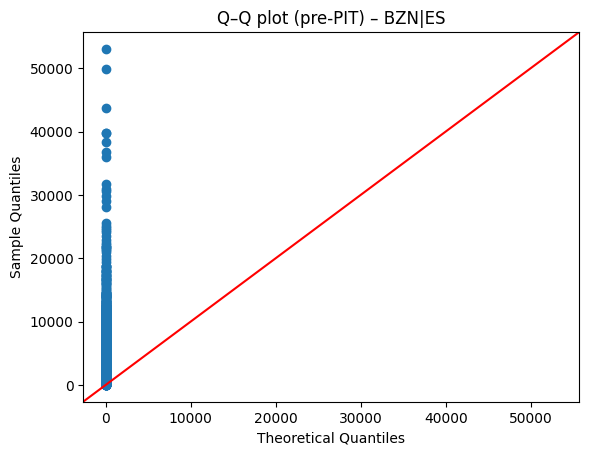

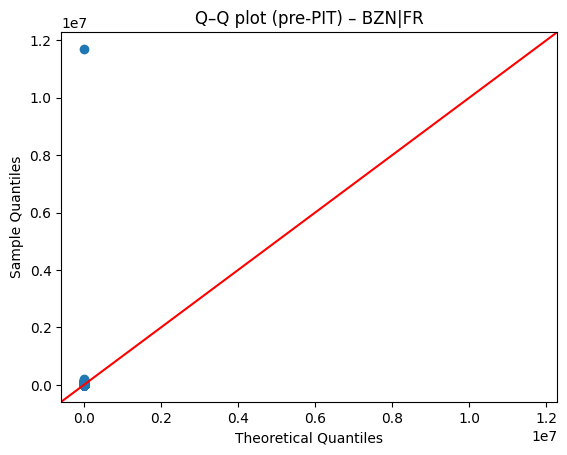

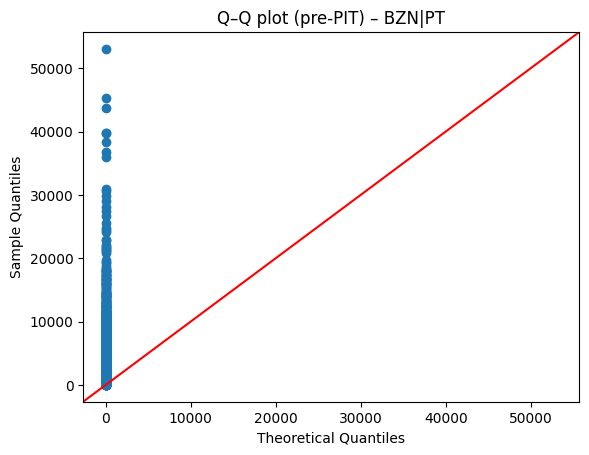

In [ ]:
# Q-Q plots BEFORE PIT

for col in daily_vars.columns:
    sm.qqplot(daily_vars[col].dropna(), line="45")
    plt.title(f"Q–Q plot (pre-PIT) – {col}")
    plt.show()


C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


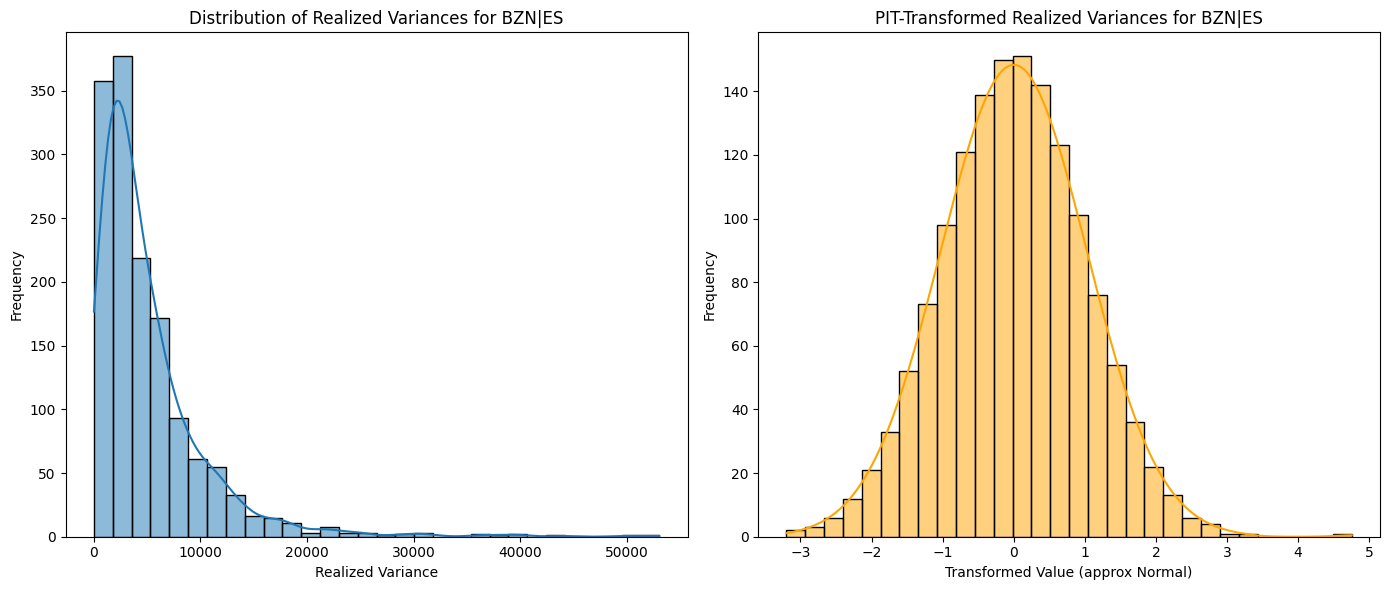

In [18]:
# Estimate the empirical cumulative distribution function (CDF) for each market's realized variances
# and apply the Probability Integral Transform (PIT) to stabilize variance and achieve approximate normality.
#
# The PIT is performed by:
# 1. Sorting the data to estimate the empirical CDF values for each observation.
# 2. Using these CDF values as inputs to the inverse standard normal CDF (norm.ppf),
#    which transforms the data to follow an approximately standard normal distribution.
#
# Clipping the CDF values avoids issues with extreme 0 or 1 probabilities, which would
# lead to infinite values after the inverse normal transform.

def pit_transform(x):
    sorted_x = np.sort(x)
    cdf_vals = np.searchsorted(sorted_x, x, side='right') / len(x)
    # Avoid exact 0 or 1 for norm.ppf by clipping
    cdf_vals = np.clip(cdf_vals, 1e-6, 1-1e-6)
    return norm.ppf(cdf_vals)

pit_vars = daily_vars.apply(pit_transform, axis=0)

# Plot distributions before and after PIT transform for a selected market
market = daily_vars.columns[0]  # choose the first market as example

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(daily_vars[market], bins=30, kde=True)
plt.title(f'Distribution of Realized Variances for {market}')
plt.xlabel('Realized Variance')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(pit_vars[market], bins=30, kde=True, color='orange')
plt.title(f'PIT-Transformed Realized Variances for {market}')
plt.xlabel('Transformed Value (approx Normal)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [19]:
# --- Normality tests AFTER PIT -------------------------------------------
norm_post = normality_stats(pit_vars)
display(norm_post)


,shapiro_p,jb_p,ad_p
series,,,
BZN|ES,0.530456,0.223949,0.005
BZN|FR,0.530456,0.223949,0.005
BZN|PT,0.530456,0.223949,0.005


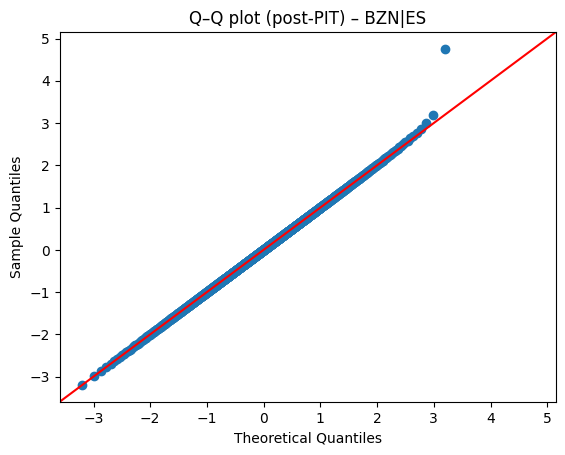

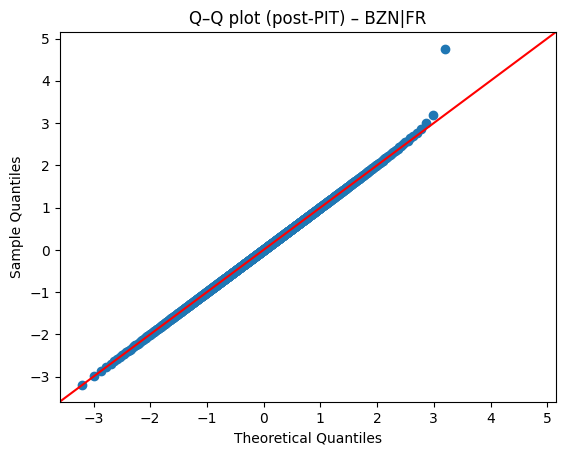

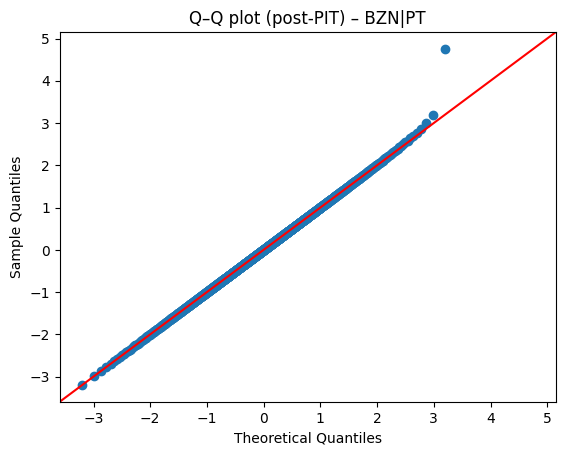

In [20]:
# --- Q-Q plots AFTER PIT --------------------------------------------------
for col in pit_vars.columns:
    sm.qqplot(pit_vars[col].dropna(), line="45")
    plt.title(f"Q–Q plot (post-PIT) – {col}")
    plt.show()


 ## Step 5: Save outputs for modeling

In [21]:
# Save simple returns (without Date column)
simple_returns.drop(columns='Date').to_parquet(f"parquet_files/simple_returns_{option_selector.value}.parquet")

# Save daily realized covariance matrices as a single parquet with MultiIndex (day + market pairs)
# Flatten daily covariance matrices into long format for storage
records = []
for day, cov in daily_covariances.items():
    for i, mkt1 in enumerate(cov.index):
        for j, mkt2 in enumerate(cov.columns):
            records.append({'Date': day, 'Market1': mkt1, 'Market2': mkt2, 'Value': cov.iloc[i,j]})

daily_cov_long = pd.DataFrame(records)
daily_cov_long.to_parquet(f"parquet_files/daily_realized_covariances_{option_selector.value}.parquet")

# Save PIT-transformed variances
pit_vars.to_parquet(f"parquet_files/pit_transformed_variances_{option_selector.value}.parquet")


## Step 6: Construct PIT-transformed vech vectors for realized covariances

From Daily Realised Covariances → vech-vector → Probability-Integral Transform (PIT)

Given  

* intraday returns $r_{d,t}\in\mathbb R^{n}$  for trading day $d=1,\dots,D$ and time slice $t=1,\dots,T_d$,

the **daily realised covariance matrix** is  

$$
\mathbf R_{d}\;=\;\sum_{t=1}^{T_d} r_{d,t}\,r_{d,t}^\top
\quad\in\mathbb R^{n\times n}.
$$

---

### 1 .  “vech” vectorisation  
Because \(\mathbf R_d\) is symmetric, we keep only its diagonal and strict-lower-triangle:

$$
\operatorname{vech}(\mathbf R_d)
=\bigl(R_{d,11},R_{d,21},\dots,R_{d,n1},
        R_{d,22},R_{d,32},\dots,R_{d,nn}\bigr)^\top
\;\in\;\mathbb R^{\,n(n+1)/2}.
$$

Stacking these row-wise over all $D$ days yields an $D\times n(n+1)/2$ data frame.

---

### 2 .  Probability-Integral Transform  
For **each** entry $x_{d,ij}=R_{d,ij}$ (fixed $i,j$):

1. **Empirical CDF**  
   $$
     \hat F_{ij}(x)
     =\frac{1}{D}\sum_{d=1}^{D}\mathbf 1\{x_{d,ij}\le x\}.
   $$
2. **Clip** the extremal probabilities:  
   $\tilde F_{ij}(x)=\mathrm{clip}\bigl(\hat F_{ij}(x),\varepsilon,1-\varepsilon\bigr)$,
   with $\varepsilon=10^{-6}$.
3. **Gaussianise** with the inverse standard-normal CDF  
   $$
     z_{d,ij}=\Phi^{-1}\bigl(\tilde F_{ij}(x_{d,ij})\bigr)
     \quad\sim\text{approximately } \mathcal N(0,1).
   $$

The transformed matrix $Z$ keeps the cross–sectional dependence structure but now has **marginally standard-normal entries**, which stabilises variances and facilitates multivariate modelling (e.g. copulas, PCA, VAR).

---

*(Below is the fully commented Python block that implements these steps.)*

In [22]:

# generate (i,j) indices for the vech operator
def vech_indexer(n: int):
    """
    Return a list of (row, col) pairs for the lower triangle of an n×n matrix,
    including the diagonal, ordered in column-major 'vech' style:
    (0,0), (1,0), …, (n-1,0), (1,1), (2,1), …
    """
    return [(i, j) for i in range(n) for j in range(i + 1)]


def build_vech_dataframe(daily_covariances):
    example = next(iter(daily_covariances.values()))
    markets = example.columns.tolist()

    # Generate vech-style column names
    index_labels = []
    for i in range(len(markets)):
        for j in range(i + 1):
            if i == j:
                index_labels.append(f"{markets[i]}")
            else:
                index_labels.append(f"{markets[i]}-{markets[j]}")

    # Ensure consistent ordering by sorting days
    records = []
    dates = []
    for day in sorted(daily_covariances.keys()):
        cov = daily_covariances[day]
        mat = cov.values
        vech_vals = mat[np.tril_indices(len(mat))]
        records.append(vech_vals)
        dates.append(day)

    df = pd.DataFrame(records, index=pd.to_datetime(dates), columns=index_labels)
    return df, index_labels

# Step 1: Build vech DF across all days
vech_df, vech_labels = build_vech_dataframe(daily_covariances)






In [23]:
vech_df.head()

,BZN|ES,BZN|FR-BZN|ES,BZN|FR,BZN|PT-BZN|ES,BZN|PT-BZN|FR,BZN|PT
2021-05-21,900.7055,610.1282,3308.8123,849.2810,396.1419,856.6119
2021-05-22,638.1532,546.4453,2775.8191,638.1532,546.4453,638.1532
2021-05-23,787.1981,596.2553,3423.8128,787.1981,596.2553,787.1981
2021-05-24,865.9875,770.1017,3088.8052,865.9875,770.1017,865.9875
2021-05-25,262.7337,341.5632,1546.6911,251.8947,320.1967,245.3007


In [24]:
# -------------------------------------------------------------------------
# Robust Jarque–Bera wrapper: works with either statsmodels or scipy
# -------------------------------------------------------------------------
try:
    # statsmodels gives (stat, p, skew, kurtosis)
    from statsmodels.stats.stattools import jarque_bera as _jb
    _JB_RETURNS_FOUR = True
except ImportError:                 # fall back on scipy
    from scipy.stats import jarque_bera as _jb
    _JB_RETURNS_FOUR = False


def jb_test(df):
    """
    Compute Jarque–Bera normality p-values (plus skew & kurtosis when possible)
    for every column in *df*.  Returns a tidy DataFrame.
    """
    records = []
    for col in df.columns:
        res = _jb(df[col].dropna())
        if _JB_RETURNS_FOUR:           # statsmodels
            jb_stat, jb_p, skew, kurt = res
        else:                          # scipy (stat, p)
            jb_stat, jb_p = res
            skew = kurt = float('nan')  # placeholders

        records.append(
            dict(series=col, jb_stat=jb_stat, jb_p=jb_p,
                 skew=skew, kurtosis_excess=kurt)
        )
    return (pd.DataFrame(records)
            .set_index("series")
            .sort_values("jb_p"))

# === JB normality BEFORE PIT ===========================================
jb_pre = jb_test(vech_df)
display(jb_pre)


,jb_stat,jb_p,skew,kurtosis_excess
series,,,,
BZN|ES,1.846444e+04,0.0,3.178954,19.343319
BZN|FR-BZN|ES,2.472382e+05,0.0,5.912786,66.070854
BZN|FR,1.225996e+08,0.0,37.742777,1429.958626
BZN|PT-BZN|ES,2.139966e+04,0.0,3.343332,20.655085
BZN|PT-BZN|FR,1.407934e+05,0.0,5.055010,50.357318
BZN|PT,1.953292e+04,0.0,3.259236,19.817617


In [25]:

# Step 2: Apply PIT across time (column-wise)
def pit_transform_columnwise(df):
    transformed = df.copy()
    for col in df.columns:
        x = df[col].values
        cdf_vals = rankdata(x, method='average') / (len(x) + 1)
        cdf_vals = np.clip(cdf_vals, 1e-6, 1 - 1e-6)
        transformed[col] = norm.ppf(cdf_vals)
    return transformed

pit_vech = pit_transform_columnwise(vech_df)

# Step 3: Save PIT-transformed data and vech labels
pit_vech.to_parquet(f"parquet_files/pit_transformed_vech_{option_selector.value}.parquet")

with open(f"parquet_files/vech_labels_{option_selector.value}.json", "w") as f:
    json.dump(vech_labels, f)

# Optional: preview
pit_vech.head()


,BZN|ES,BZN|FR-BZN|ES,BZN|FR,BZN|PT-BZN|ES,BZN|PT-BZN|FR,BZN|PT
2021-05-21,-1.228818,-1.092488,-0.470493,-1.217797,-1.228818,-1.221454
2021-05-22,-1.374748,-1.164787,-0.682148,-1.344093,-1.086195,-1.352723
2021-05-23,-1.322947,-1.105205,-0.426281,-1.274471,-1.040308,-1.290294
2021-05-24,-1.239990,-0.930160,-0.541632,-1.185592,-0.867669,-1.210532
2021-05-25,-1.748117,-1.352723,-1.203330,-1.732314,-1.331334,-1.748117


In [26]:
# === JB normality AFTER PIT ==============================================
jb_post = jb_test(pit_vech)        # jb_test wrapper defined earlier
display(jb_post)


,jb_stat,jb_p,skew,kurtosis_excess
series,,,,
BZN|PT-BZN|FR,0.36263,0.834173,2.398342e-16,2.922285
BZN|PT,0.36263,0.834173,1.798757e-16,2.922285
BZN|ES,0.36263,0.834173,2.398342e-16,2.922285
BZN|FR-BZN|ES,0.36263,0.834173,2.398342e-16,2.922285
BZN|FR,0.36263,0.834173,1.598895e-16,2.922285
BZN|PT-BZN|ES,0.36263,0.834173,1.998618e-16,2.922285


In [29]:
# === Unit-root checks AFTER PIT: ADF, PP, DF-GLS =========================
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Phillips-Perron helper (statsmodels ≥0.13 preferred; fallback to arch)
try:
    from statsmodels.tsa.stattools import phillips_perron
    def pp_pvalue(x, lags=None, trend='c'):
        return phillips_perron(x, lags=lags, trend=trend)[1]
except ImportError:                    # fall back on arch's implementation
    from arch.unitroot import PhillipsPerron
    def pp_pvalue(x, lags=None, trend='c'):
        return PhillipsPerron(x, lags=lags, trend=trend).pvalue

# DF-GLS (Elliott-Rothenberg-Stock)—handy in multivariate / small-sample work
from arch.unitroot import DFGLS

def unit_root_tests(df, maxlag=12, pp_lags=None, trend='c'):
    """
    Returns a DataFrame with p-values for ADF, Phillips-Perron and DF-GLS.
    trend ∈ {'c','ct','nc'}: constant / constant+trend / no constant.
    """
    results = []
    for col in df.columns:
        series = df[col].dropna()

        adf_p   = adfuller(series, maxlag=maxlag, autolag='BIC', regression=trend)[1]
        pp_p    = pp_pvalue(series, lags=pp_lags, trend=trend)
        dfgls_p = DFGLS(series, trend=trend).pvalue

        results.append(dict(series=col, adf_p=adf_p, pp_p=pp_p, dfgls_p=dfgls_p))

    return (pd.DataFrame(results)
            .set_index('series')
            .sort_values(['adf_p', 'pp_p']))

# Run the tests on the PIT-transformed vech matrix
unitroot = unit_root_tests(pit_vech)
display(unitroot)



,adf_p,pp_p,dfgls_p
series,,,
BZN|PT,9.057526e-07,0.000000e+00,0.090256
BZN|PT-BZN|ES,1.098761e-06,0.000000e+00,0.082155
BZN|ES,1.387964e-06,0.000000e+00,0.101125
BZN|FR-BZN|ES,6.040420e-06,0.000000e+00,0.139857
BZN|PT-BZN|FR,7.685591e-06,0.000000e+00,0.152267
BZN|FR,1.842372e-03,2.041228e-30,0.011749
